In [0]:
# This tutorial is to Develop a Deep Learning Model to Automatically
# Translate from German to English in Python with Keras, Step-by-Step.
# Machine translation is a challenging task that traditionally involves large statistical models 
# developed using highly sophisticated linguistic knowledge.

# Neural machine translation is the use of deep neural networks for the problem of machine translation.

# In this tutorial, you will discover how to develop a neural machine translation system for translating German phrases to English.

# After completing this tutorial, you will know:

# How to clean and prepare data ready to train a neural machine translation system.
# How to develop an encoder-decoder model for machine translation.
# How to use a trained model for inference on new input phrases and evaluate the model skill.

# Tutorial Overview
# This tutorial is divided into 4 parts; they are:

# German to English Translation Dataset
# Preparing the Text Data
# Train Neural Translation Model
# Evaluate Neural Translation Model
# Python Environment
# This tutorial assumes you have a Python 3 SciPy environment installed.

# You must have Keras (2.0 or higher) installed with either the TensorFlow or Theano backend.

# The tutorial also assumes you have NumPy and Matplotlib installed.

# If you need help with your environment, see this post:

# How to Setup a Python Environment for Machine Learning and Deep Learning with Anaconda

# https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

# A GPU is not require for thus tutorial, nevertheless, you can access GPUs cheaply on Amazon Web Services. Learn how in this tutorial:

# https://machinelearningmastery.com/develop-evaluate-large-deep-learning-models-keras-amazon-web-services/

# How to Setup Amazon AWS EC2 GPUs to Train Keras Deep Learning Models (step-by-step)
# Let’s dive in.

# German to English Translation Dataset
# In this tutorial, we will use a dataset of German to English terms used as the basis for flashcards for language learning.

# The dataset is available from the ManyThings.org website, with examples drawn from the Tatoeba Project. The dataset is comprised of German phrases and their English counterparts and is intended to be used with the Anki flashcard software.

# The page provides a list of many language pairs, and I encourage you to explore other languages:

# Tab-delimited Bilingual Sentence Pairs
# The dataset we will use in this tutorial is available for download here:

# German – English deu-eng.zip
# http://www.manythings.org/anki/deu-eng.zip

# Download the dataset to your current working directory and decompress; for example:


In [0]:
!wget http://www.manythings.org/anki/deu-eng.zip

--2019-10-02 12:34:48--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4541707 (4.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   4.33M  14.8MB/s    in 0.3s    

2019-10-02 12:34:49 (14.8 MB/s) - ‘deu-eng.zip’ saved [4541707/4541707]



In [0]:
!unzip deu-eng.zip # remeber to open a notebook in google colab

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [0]:
# You will have a file called deu.txt that contains 152,820 pairs of English to German phases, one pair per line with a tab separating the language.

# For example, the first 5 lines of the file look as follows:

# Hi. Hallo!
# Hi. Grüß Gott!
# Run!    Lauf!
# Wow!    Potzdonner!
# Wow!    Donnerwetter!
# 1
# 2
# 3
# 4
# 5
# Hi. Hallo!
# Hi. Grüß Gott!
# Run!    Lauf!
# Wow!    Potzdonner!
# Wow!    Donnerwetter!


# We will frame the prediction problem as given a sequence of words in German as input, translate or predict the sequence of words in English.

# The model we will develop will be suitable for some beginner German phrases.

# Preparing the Text Data
# The next step is to prepare the text data ready for modeling.

# If you are new to cleaning text data, see this post:

In [0]:
# How to Clean Text for Machine Learning with Python
# https://machinelearningmastery.com/clean-text-machine-learning-python/

# Take a look at the raw data and note what you see that we might need to handle in a data cleaning operation.

# For example, here are some observations I note from reviewing the raw data:

# There is punctuation.
# The text contains uppercase and lowercase.
# There are special characters in the German.
# There are duplicate phrases in English with different translations in German.
# The file is ordered by sentence length with very long sentences toward the end of the file.
# Did you note anything else that could be important?
# Let me know in the comments below.

# A good text cleaning procedure may handle some or all of these observations.

# Data preparation is divided into two subsections:

# Clean Text
# Split Text
# 1. Clean Text
# First, we must load the data in a way that preserves the Unicode German characters. The function below called load_doc() will load the file as a blob of text.

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# Each line contains a single pair of phrases, 
# first English and then German, separated by a tab character.
# We must split the loaded text by line and then by phrase.
# The function to_pairs() below will split the loaded text.

# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [0]:
# We are now ready to clean each sentence. The specific cleaning operations we will perform are as follows:

# Remove all non-printable characters.
# Remove all punctuation characters.
# Normalize all Unicode characters to ASCII (e.g. Latin characters).
# Normalize the case to lowercase.
# Remove any remaining tokens that are not alphabetic.
# We will perform these operations on each phrase for each pair in the loaded dataset.

# The clean_pairs() function below implements these operations.

# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [0]:
# Finally, now that the data has been cleaned,
# we can save the list of phrase pairs to a file ready for use.

# The function save_clean_data() uses the pickle API to 
# save the list of clean text to file.

# Pulling all of this together, the complete example is listed below.

import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs
 
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
 
# load dataset
filename = 'deu.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-german.pkl')
# spot check
for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

In [0]:
# 2. Split Text
# The clean data contains a little over 150,000 phrase pairs and some of the 
# pairs toward the end of the file are very long.

# This is a good number of examples for developing a small translation model.
# The complexity of the model increases with the number of examples, length of phrases, and size of 
# the vocabulary.

# Although we have a good dataset for modeling translation, 
# we will simplify the problem slightly to dramatically reduce the size of the model required, 
# and in turn the training time required to fit the model.

# You can explore developing a model on the fuller dataset as an extension; 
# I would love to hear how you do.

# We will simplify the problem by reducing the dataset to the 
# first 10,000 examples in the file; these will be the shortest phrases in the dataset.

# Further, we will then stake the first 9,000 of those as examples for training and the remaining 
# 1,000 examples to test the fit model.

# Below is the complete example of loading the clean data, splitting it,
# and saving the split portions of data to new files.

from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
 
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')


In [0]:
# Running the example creates three new files: 
# the english-german-both.pkl that contains all of the train 
# and test examples that we can use to define the parameters of the problem, 
# such as max phrase lengths and the vocabulary, and the english-german-train.pkl 
# and english-german-test.pkl files for the train and test dataset.

# We are now ready to start developing our translation model.

# Train Neural Translation Model
# In this section, we will develop the neural translation model.

# If you are new to neural translation models, see the post:

# A Gentle Introduction to Neural Machine Translation
# https://machinelearningmastery.com/introduction-neural-machine-translation/
# This involves both loading and preparing the clean text data ready 
# for modeling and defining and training the model on the prepared data.

# Let’s start off by loading the datasets so that we can prepare the data. 
# The function below named load_clean_sentences() can be used to load the train, 
# test, and both datasets in turn.

# We will use the “both” or combination of the train and test datasets to define 
# the maximum length and vocabulary of the problem.

# This is for simplicity. Alternately, we could define these properties 
# from the training dataset alone and truncate examples in the test 
# set that are too long or have words that are out of the vocabulary.

# We can use the Keras Tokenize class to map words to integers, as 
# needed for modeling. We will use separate tokenizer for the 
# English sequences and the German sequences. 
# The function below-named create_tokenizer()
#  will train a tokenizer on a list of phrases.

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# Similarly, the function named max_length()
# below will find the length of the longest sequence in a list of phrases.

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)


In [0]:
# install tokenizer
!pip3 install tokenizer

In [0]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))


In [0]:
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

In [0]:
# We are now ready to prepare the training dataset.

# Each input and output sequence must be encoded to 
# integers and padded to the maximum phrase length. 
# This is because we will use a word embedding for the input sequences 
# and one hot encode the output sequences 
# The function below named encode_sequences() 
# will perform these operations and return the result.

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X


# The output sequence needs to be one-hot encoded. 
# This is because the model will predict the probability
# of each word in the vocabulary as output.

# The function encode_output() 
# below will one-hot encode English output sequences.

# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y


In [0]:
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

# We can make use of these two functions and prepare both the 
# train and test dataset ready for training the model.

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

In [0]:
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 256)           908032    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 5, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 2215)           569255    
Total params: 2,527,911
Trainable params: 2,527,911
Non-trainable params: 0
_________________________________________________________________
None


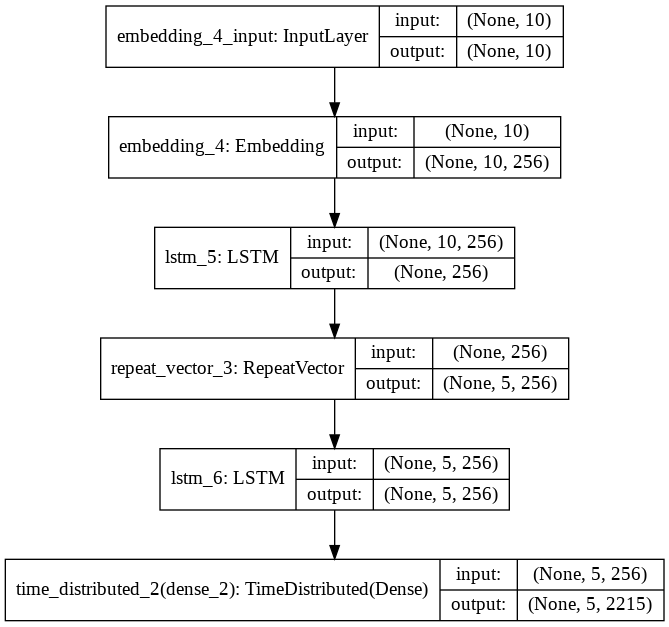

In [74]:
# We are now ready to define the model.

# We will use an encoder-decoder LSTM model on this problem. In this architecture, 
# the input sequence is encoded by a front-end model called 
# the encoder then decoded word by word by a backend model called the decoder.

# The function define_model() below defines the model and takes a 
# number of arguments used to configure the model, 
# such as the size of the input and output vocabularies, 
# the maximum length of input and output phrases, 
# and the number of memory units used to configure the model.

# The model is trained using the efficient Adam 
# approach to stochastic gradient descent and minimizes 
# the categorical loss function because 
# we have framed the prediction problem as multi-class classification.

# The model configuration was not optimized for 
# this problem, meaning that there is plenty of opportunity for you to tune it and lift the skill 
# of the translations. I would love to see what you can come up with.

# For more advice on configuring neural machine translation models, see the post:

# How to Configure an Encoder-Decoder Model for Neural Machine Translation

# https://machinelearningmastery.com/configure-encoder-decoder-model-neural-machine-translation/

from keras.models import Sequential

from keras.layers import Embedding

from keras.layers import LSTM

from keras.layers import RepeatVector

from keras.layers import TimeDistributed

from keras.layers import Dense

from keras.utils.vis_utils import plot_model

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)